# Discrete Event Simulation with spark-bestfit

This notebook demonstrates how to use **distribution fitting** to power realistic
**discrete event simulations** for operational decision-making.

## What You'll Learn

1. **Fit distributions** to real operational data (arrivals, service times)
2. **Validate assumptions** - is it really Poisson? Test with KS!
3. **Build queue simulations** using fitted distributions
4. **Run what-if scenarios** to guide staffing decisions
5. **Quantify uncertainty** with confidence intervals

## Business Context

Operations teams often need to answer questions like:
- "If we add 2 more agents, how much will wait times decrease?"
- "What happens to service levels if call volume increases 20%?"
- "Is investing in training (reducing handle time) worth it?"

**The Problem**: These decisions are expensive and hard to reverse. You can't
easily experiment with real operations.

**The Solution**: Fit distributions to historical data, then simulate scenarios
to predict outcomes before committing resources.

## Prerequisites

```bash
pip install spark-bestfit pandas numpy matplotlib scipy
```

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from spark_bestfit import DistributionFitter, DiscreteDistributionFitter

# Create Spark session
spark = SparkSession.builder \
    .appName("DiscreteEventSimulation") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print(f"Spark version: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/03 00:06:20 WARN Utils: Your hostname, 2025m5.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.201 instead (on interface en0)
26/01/03 00:06:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/03 00:06:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 4.1.0


## Part 1: Generate Realistic Call Center Data

In production, this would be historical data from your systems. We'll simulate
realistic call center operations with:

- **Arrivals**: Non-homogeneous Poisson (higher rates during business hours)
- **Service times**: Lognormal (right-skewed, some long calls)
- **Abandonment**: Customers who hang up after waiting too long

In [2]:
np.random.seed(42)

def generate_call_center_data(n_days=30, base_rate=50):
    """
    Generate realistic call center data.
    
    Returns DataFrame with: timestamp, inter_arrival_time, service_time, 
    hour_of_day, day_of_week, abandoned
    """
    records = []
    
    for day in range(n_days):
        day_of_week = day % 7  # 0=Monday, 6=Sunday
        
        # Simulate each hour of operation (8 AM to 8 PM)
        for hour in range(8, 20):
            # Arrival rate varies by hour (peak at 10-11 AM and 2-3 PM)
            hour_factor = 1.0
            if hour in [10, 11]:
                hour_factor = 1.8  # Morning peak
            elif hour in [14, 15]:
                hour_factor = 1.5  # Afternoon peak
            elif hour in [8, 19]:
                hour_factor = 0.6  # Start/end of day slower
            
            # Weekend factor
            if day_of_week >= 5:
                hour_factor *= 0.4  # Much lower on weekends
            
            # Number of calls this hour (Poisson)
            hourly_rate = base_rate * hour_factor
            n_calls = np.random.poisson(hourly_rate)
            
            # Generate inter-arrival times (exponential with some burstiness)
            # Real data often shows slight overdispersion
            if n_calls > 0:
                # Use Weibull instead of pure exponential for slight burstiness
                inter_arrivals = stats.weibull_min.rvs(c=0.9, scale=60/hourly_rate*60, size=n_calls)
                
                # Service times: lognormal (right-skewed)
                # Average ~5 minutes, but some calls much longer
                service_times = stats.lognorm.rvs(s=0.6, scale=300, size=n_calls)  # seconds
                
                # Abandonment probability increases with expected wait
                # (simplified - in reality depends on queue state)
                abandon_prob = 0.05 + 0.02 * (hourly_rate / base_rate - 1)
                abandoned = np.random.binomial(1, abandon_prob, n_calls)
                
                for i in range(n_calls):
                    records.append({
                        'day': day,
                        'hour': hour,
                        'day_of_week': day_of_week,
                        'inter_arrival_seconds': inter_arrivals[i],
                        'service_time_seconds': service_times[i],
                        'abandoned': abandoned[i]
                    })
    
    return pd.DataFrame(records)

# Generate 30 days of call center data
call_data = generate_call_center_data(n_days=30, base_rate=50)

print(f"Generated {len(call_data):,} call records over 30 days")
print(f"\nSample data:")
print(call_data.head(10))

Generated 17,320 call records over 30 days

Sample data:
   day  hour  day_of_week  inter_arrival_seconds  service_time_seconds  \
0    0     8            0             162.915026            150.383144   
1    0     8            0             108.449992            375.854194   
2    0     8            0              16.713157            209.222705   
3    0     8            0              16.710029            251.833014   
4    0     8            0               5.251376            209.088688   
5    0     8            0             260.832175            911.552678   
6    0     8            0             109.260665            297.580310   
7    0     8            0             151.204942            159.040028   
8    0     8            0               1.623105            491.425043   
9    0     8            0             483.271873            144.210824   

   abandoned  
0          0  
1          0  
2          0  
3          0  
4          0  
5          0  
6          0  
7       

In [3]:
# Summary statistics
print("Call Center Data Summary:")
print(f"\nTotal calls: {len(call_data):,}")
print(f"Abandoned calls: {call_data['abandoned'].sum():,} ({call_data['abandoned'].mean():.1%})")
print(f"\nInter-arrival times (seconds):")
print(f"  Mean: {call_data['inter_arrival_seconds'].mean():.1f}")
print(f"  Median: {call_data['inter_arrival_seconds'].median():.1f}")
print(f"  Std: {call_data['inter_arrival_seconds'].std():.1f}")
print(f"\nService times (seconds):")
print(f"  Mean: {call_data['service_time_seconds'].mean():.1f} ({call_data['service_time_seconds'].mean()/60:.1f} min)")
print(f"  Median: {call_data['service_time_seconds'].median():.1f} ({call_data['service_time_seconds'].median()/60:.1f} min)")
print(f"  Std: {call_data['service_time_seconds'].std():.1f}")

Call Center Data Summary:

Total calls: 17,320
Abandoned calls: 921 (5.3%)

Inter-arrival times (seconds):
  Mean: 78.2
  Median: 42.8
  Std: 109.5

Service times (seconds):
  Mean: 357.4 (6.0 min)
  Median: 299.3 (5.0 min)
  Std: 232.8


## Part 2: Exploratory Data Analysis

Before fitting distributions, let's understand our data patterns.

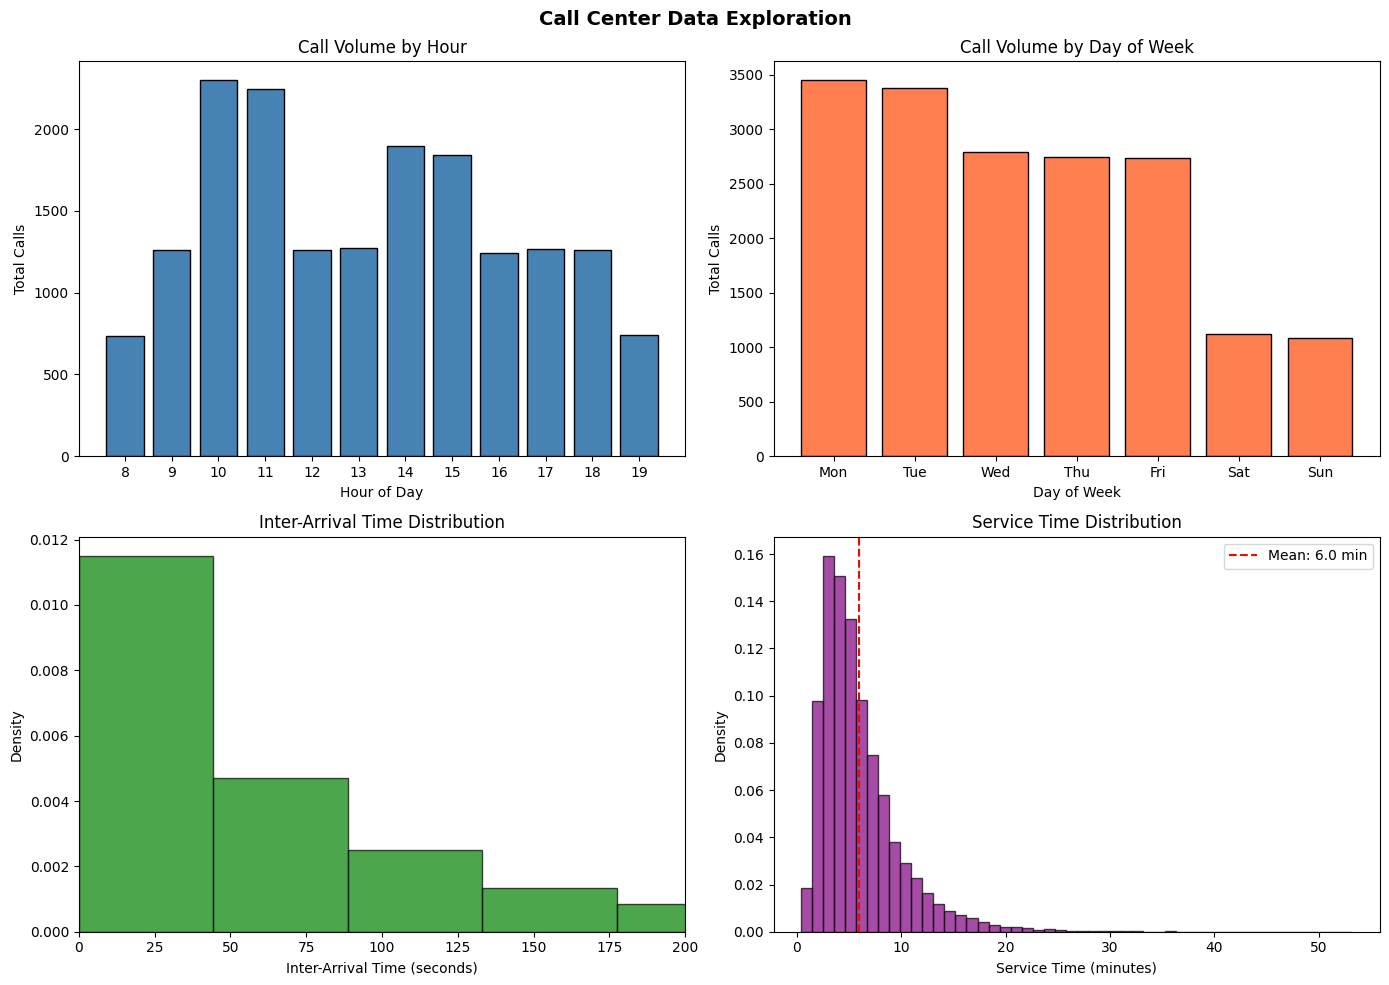

In [4]:
# Visualize patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Calls by hour
hourly_calls = call_data.groupby('hour').size()
axes[0, 0].bar(hourly_calls.index, hourly_calls.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Total Calls')
axes[0, 0].set_title('Call Volume by Hour')
axes[0, 0].set_xticks(range(8, 20))

# Calls by day of week
daily_calls = call_data.groupby('day_of_week').size()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), daily_calls.values, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Total Calls')
axes[0, 1].set_title('Call Volume by Day of Week')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names)

# Inter-arrival time distribution
axes[1, 0].hist(call_data['inter_arrival_seconds'], bins=50, density=True, 
                alpha=0.7, color='green', edgecolor='black')
axes[1, 0].set_xlabel('Inter-Arrival Time (seconds)')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Inter-Arrival Time Distribution')
axes[1, 0].set_xlim(0, 200)

# Service time distribution
axes[1, 1].hist(call_data['service_time_seconds'] / 60, bins=50, density=True,
                alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_xlabel('Service Time (minutes)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Service Time Distribution')
axes[1, 1].axvline(call_data['service_time_seconds'].mean()/60, color='red', 
                   linestyle='--', label=f"Mean: {call_data['service_time_seconds'].mean()/60:.1f} min")
axes[1, 1].legend()

plt.suptitle('Call Center Data Exploration', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Part 3: Fit Distributions to Operational Processes

Now we'll use spark-bestfit to identify the best distributions for:

1. **Inter-arrival times** (continuous) - How long between calls?
2. **Service times** (continuous) - How long does each call take?
3. **Hourly call volume** (discrete) - How many calls per hour?

In [5]:
# Convert to Spark DataFrames
call_spark = spark.createDataFrame(call_data)

# Create hourly aggregates for discrete fitting
hourly_volumes = call_data.groupby(['day', 'hour']).size().reset_index(name='call_count')
hourly_spark = spark.createDataFrame(hourly_volumes)

print(f"Call-level data: {call_spark.count():,} records")
print(f"Hourly aggregates: {hourly_spark.count():,} records")

[Stage 0:>                                                        (0 + 10) / 10]

Call-level data: 17,320 records
Hourly aggregates: 360 records


In [6]:
# Fit continuous distributions to inter-arrival and service times
cont_fitter = DistributionFitter(spark)

# Inter-arrival times
interarrival_results = cont_fitter.fit(
    call_spark,
    column='inter_arrival_seconds',
    max_distributions=20,
    lazy_metrics=False  # We want KS for validation
)

# Service times
service_results = cont_fitter.fit(
    call_spark,
    column='service_time_seconds',
    max_distributions=20,
    lazy_metrics=False
)

print(f"Fitted {interarrival_results.count()} distributions to inter-arrival times")
print(f"Fitted {service_results.count()} distributions to service times")

Fitted 20 distributions to inter-arrival times
Fitted 20 distributions to service times


In [7]:
# Best fits for inter-arrival times
print("INTER-ARRIVAL TIMES - Best Distributions:")
print("\nBy AIC (prediction):")
for i, fit in enumerate(interarrival_results.best(n=5, metric='aic'), 1):
    print(f"  {i}. {fit.distribution}: AIC={fit.aic:.1f}")

print("\nBy KS (goodness-of-fit):")
for i, fit in enumerate(interarrival_results.best(n=5, metric='ks_statistic'), 1):
    pval = fit.pvalue if fit.pvalue else 0
    print(f"  {i}. {fit.distribution}: KS={fit.ks_statistic:.4f}, p={pval:.4f}")

INTER-ARRIVAL TIMES - Best Distributions:

By AIC (prediction):
  1. betaprime: AIC=106573.6
  2. burr12: AIC=106581.8
  3. exponweib: AIC=106668.4
  4. burr: AIC=106669.3
  5. erlang: AIC=106854.6

By KS (goodness-of-fit):
  1. betaprime: KS=0.0062, p=0.8332
  2. burr12: KS=0.0104, p=0.2296
  3. burr: KS=0.0189, p=0.0015
  4. exponweib: KS=0.0201, p=0.0006
  5. erlang: KS=0.0261, p=0.0000


In [8]:
# Best fits for service times
print("SERVICE TIMES - Best Distributions:")
print("\nBy AIC (prediction):")
for i, fit in enumerate(service_results.best(n=5, metric='aic'), 1):
    print(f"  {i}. {fit.distribution}: AIC={fit.aic:.1f}")

print("\nBy KS (goodness-of-fit):")
for i, fit in enumerate(service_results.best(n=5, metric='ks_statistic'), 1):
    pval = fit.pvalue if fit.pvalue else 0
    print(f"  {i}. {fit.distribution}: KS={fit.ks_statistic:.4f}, p={pval:.4f}")

SERVICE TIMES - Best Distributions:

By AIC (prediction):
  1. betaprime: AIC=132286.9
  2. exponnorm: AIC=132338.7
  3. alpha: AIC=132443.1
  4. burr: AIC=132469.2
  5. burr12: AIC=132482.0

By KS (goodness-of-fit):
  1. betaprime: KS=0.0098, p=0.2931
  2. exponnorm: KS=0.0177, p=0.0038
  3. alpha: KS=0.0190, p=0.0014
  4. burr: KS=0.0193, p=0.0012
  5. burr12: KS=0.0212, p=0.0002


In [9]:
# Fit discrete distributions to hourly call volumes
disc_fitter = DiscreteDistributionFitter(spark)

volume_results = disc_fitter.fit(
    hourly_spark,
    column='call_count'
)

print("HOURLY CALL VOLUME - Best Distributions:")
print("\nBy AIC:")
for i, fit in enumerate(volume_results.best(n=5, metric='aic'), 1):
    print(f"  {i}. {fit.distribution}: AIC={fit.aic:.1f}")

HOURLY CALL VOLUME - Best Distributions:

By AIC:
  1. betabinom: AIC=3279.4
  2. nbinom: AIC=3282.1
  3. skellam: AIC=3316.5
  4. geom: AIC=3503.4
  5. planck: AIC=3518.4


## Part 4: Validate Common Assumptions

Operations research often assumes:
- Arrivals are **Poisson** → inter-arrivals are **Exponential**
- Service times are **Exponential** (for M/M/c queues)

Let's test these assumptions with our data!

In [10]:
# Find exponential fit for inter-arrivals
exp_interarrival = None
for fit in interarrival_results.best(n=50, metric='aic'):
    if fit.distribution == 'expon':
        exp_interarrival = fit
        break

# Find exponential fit for service times
exp_service = None
for fit in service_results.best(n=50, metric='aic'):
    if fit.distribution == 'expon':
        exp_service = fit
        break

# Get best overall fits
best_interarrival = interarrival_results.best(n=1, metric='aic')[0]
best_service = service_results.best(n=1, metric='aic')[0]

print("ASSUMPTION TESTING")
print("="*60)

print("\n1. Inter-Arrival Times - Is Exponential appropriate?")
if exp_interarrival:
    print(f"   Exponential: AIC={exp_interarrival.aic:.1f}, KS p-value={exp_interarrival.pvalue:.4f}")
    print(f"   Best fit ({best_interarrival.distribution}): AIC={best_interarrival.aic:.1f}")
    aic_diff = exp_interarrival.aic - best_interarrival.aic
    if aic_diff < 10:
        print(f"   VERDICT: Exponential is ACCEPTABLE (AIC diff={aic_diff:.1f})")
    else:
        print(f"   VERDICT: Exponential is POOR (AIC diff={aic_diff:.1f})")
        print(f"   RECOMMENDATION: Use {best_interarrival.distribution} instead")

print("\n2. Service Times - Is Exponential appropriate?")
if exp_service:
    print(f"   Exponential: AIC={exp_service.aic:.1f}, KS p-value={exp_service.pvalue:.4f}")
    print(f"   Best fit ({best_service.distribution}): AIC={best_service.aic:.1f}")
    aic_diff = exp_service.aic - best_service.aic
    if aic_diff < 10:
        print(f"   VERDICT: Exponential is ACCEPTABLE (AIC diff={aic_diff:.1f})")
    else:
        print(f"   VERDICT: Exponential is POOR (AIC diff={aic_diff:.1f})")
        print(f"   RECOMMENDATION: Use {best_service.distribution} instead")

ASSUMPTION TESTING

1. Inter-Arrival Times - Is Exponential appropriate?
   Exponential: AIC=107443.8, KS p-value=0.0000
   Best fit (betaprime): AIC=106573.6
   VERDICT: Exponential is POOR (AIC diff=870.2)
   RECOMMENDATION: Use betaprime instead

2. Service Times - Is Exponential appropriate?
   Exponential: AIC=136366.9, KS p-value=0.0000
   Best fit (betaprime): AIC=132286.9
   VERDICT: Exponential is POOR (AIC diff=4080.0)
   RECOMMENDATION: Use betaprime instead


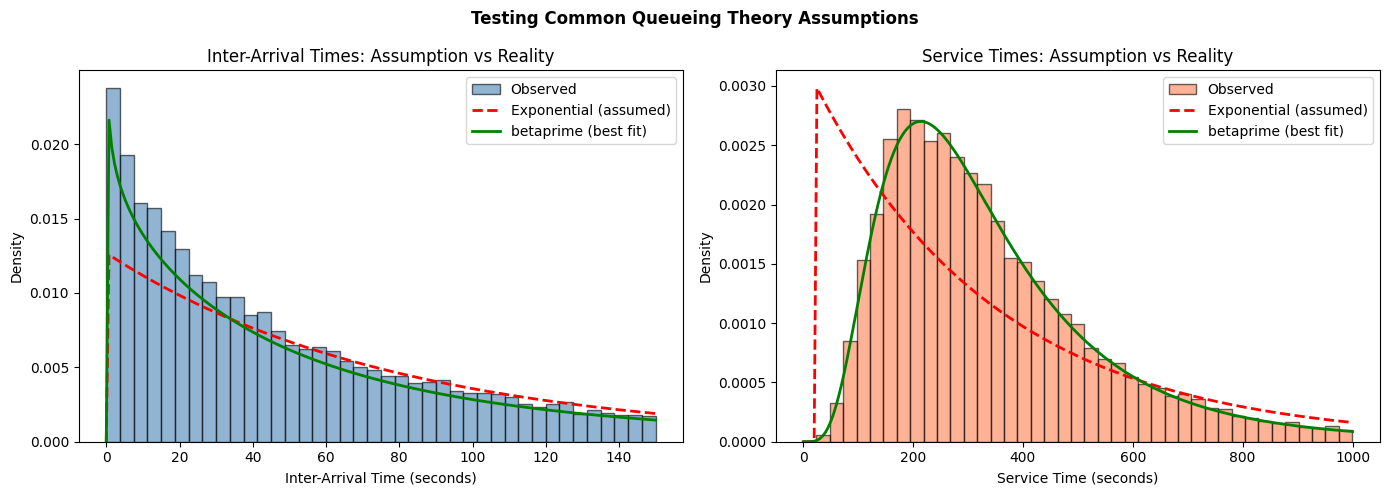

In [11]:
# Visualize assumption testing
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Inter-arrival comparison
x_ia = np.linspace(0, 150, 200)
ia_data = call_data['inter_arrival_seconds']
ia_data_plot = ia_data[ia_data < 150]

axes[0].hist(ia_data_plot, bins=40, density=True, alpha=0.6, 
             color='steelblue', edgecolor='black', label='Observed')

if exp_interarrival:
    exp_dist = exp_interarrival.get_scipy_dist()
    axes[0].plot(x_ia, exp_dist.pdf(x_ia), 'r--', lw=2, label=f'Exponential (assumed)')

best_ia_dist = best_interarrival.get_scipy_dist()
axes[0].plot(x_ia, best_ia_dist.pdf(x_ia), 'g-', lw=2, label=f'{best_interarrival.distribution} (best fit)')

axes[0].set_xlabel('Inter-Arrival Time (seconds)')
axes[0].set_ylabel('Density')
axes[0].set_title('Inter-Arrival Times: Assumption vs Reality')
axes[0].legend()

# Service time comparison
x_st = np.linspace(0, 1000, 200)
st_data = call_data['service_time_seconds']
st_data_plot = st_data[st_data < 1000]

axes[1].hist(st_data_plot, bins=40, density=True, alpha=0.6,
             color='coral', edgecolor='black', label='Observed')

if exp_service:
    exp_svc_dist = exp_service.get_scipy_dist()
    axes[1].plot(x_st, exp_svc_dist.pdf(x_st), 'r--', lw=2, label=f'Exponential (assumed)')

best_st_dist = best_service.get_scipy_dist()
axes[1].plot(x_st, best_st_dist.pdf(x_st), 'g-', lw=2, label=f'{best_service.distribution} (best fit)')

axes[1].set_xlabel('Service Time (seconds)')
axes[1].set_ylabel('Density')
axes[1].set_title('Service Times: Assumption vs Reality')
axes[1].legend()

plt.suptitle('Testing Common Queueing Theory Assumptions', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## Part 5: Build Queue Simulation

Now we'll use our fitted distributions to simulate a call center queue.
This is a simple G/G/c queue (general arrival, general service, c servers).

In [12]:
def simulate_queue(n_agents, n_calls, arrival_dist, service_dist, seed=None):
    """
    Simulate a G/G/c queue using fitted distributions.
    
    Args:
        n_agents: Number of agents (servers)
        n_calls: Number of calls to simulate
        arrival_dist: Frozen scipy distribution for inter-arrival times
        service_dist: Frozen scipy distribution for service times
        seed: Random seed
    
    Returns:
        dict with simulation results
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Generate arrivals and service times from fitted distributions
    inter_arrivals = arrival_dist.rvs(size=n_calls)
    service_times = service_dist.rvs(size=n_calls)
    
    # Ensure positive values
    inter_arrivals = np.maximum(inter_arrivals, 0.1)
    service_times = np.maximum(service_times, 1.0)
    
    # Calculate arrival times
    arrival_times = np.cumsum(inter_arrivals)
    
    # Track when each agent becomes free
    agent_free_at = np.zeros(n_agents)
    
    wait_times = []
    
    for i in range(n_calls):
        arrival = arrival_times[i]
        service = service_times[i]
        
        # Find the agent who becomes free first
        next_free_agent = np.argmin(agent_free_at)
        free_time = agent_free_at[next_free_agent]
        
        # Wait time = time until agent is free (0 if agent already free)
        wait = max(0, free_time - arrival)
        wait_times.append(wait)
        
        # Update when this agent will be free
        start_service = max(arrival, free_time)
        agent_free_at[next_free_agent] = start_service + service
    
    wait_times = np.array(wait_times)
    
    return {
        'n_agents': n_agents,
        'n_calls': n_calls,
        'mean_wait': wait_times.mean(),
        'median_wait': np.median(wait_times),
        'p95_wait': np.percentile(wait_times, 95),
        'pct_immediate': (wait_times == 0).mean() * 100,
        'pct_under_60s': (wait_times < 60).mean() * 100,
        'wait_times': wait_times
    }

# Get fitted distributions
arrival_dist = best_interarrival.get_scipy_dist()
service_dist = best_service.get_scipy_dist()

print(f"Using distributions:")
print(f"  Arrivals: {best_interarrival.distribution}")
print(f"  Service: {best_service.distribution}")

Using distributions:
  Arrivals: betaprime
  Service: betaprime


In [ ]:
# Run baseline simulation (5 agents, peak hour volume)
# Simulate 2000 calls (roughly 2 peak hours)
baseline = simulate_queue(
    n_agents=5,
    n_calls=2000,
    arrival_dist=arrival_dist,
    service_dist=service_dist,
    seed=42
)

print("BASELINE SIMULATION (5 Agents)")
print("="*50)
print(f"Calls simulated: {baseline['n_calls']:,}")
print(f"\nWait Time Metrics:")
print(f"  Mean wait: {baseline['mean_wait']:.1f} seconds ({baseline['mean_wait']/60:.1f} min)")
print(f"  Median wait: {baseline['median_wait']:.1f} seconds")
print(f"  95th percentile: {baseline['p95_wait']:.1f} seconds ({baseline['p95_wait']/60:.1f} min)")
print(f"\nService Level:")
print(f"  Answered immediately: {baseline['pct_immediate']:.1f}%")
print(f"  Answered within 60s: {baseline['pct_under_60s']:.1f}%")

# Calculate and explain utilization (why wait times are so high)
mean_interarrival = call_data['inter_arrival_seconds'].mean()
mean_service = call_data['service_time_seconds'].mean()
n_agents = 5
utilization = (mean_service / mean_interarrival) / n_agents

print(f"\n{'Understanding the Results':^50}")
print("-"*50)
print(f"  Mean inter-arrival time: {mean_interarrival:.1f}s")
print(f"  Mean service time: {mean_service:.1f}s ({mean_service/60:.1f} min)")
print(f"  System utilization (ρ): {utilization:.1%}")
print(f"\n  NOTE: Utilization > 90% causes exponential queue growth!")
print(f"  At ρ={utilization:.0%}, the system is severely overloaded.")

## Part 6: What-If Scenario Analysis

Now the powerful part: simulate different scenarios to guide decisions.

In [ ]:
def run_scenario_analysis(arrival_dist, service_dist, n_calls=2000, n_simulations=20):
    """
    Run multiple scenarios with confidence intervals.
    
    Note on scaling: For "20% more calls" and "10% faster service" scenarios, we 
    scale the sampled values directly rather than re-parameterizing the distribution.
    This is a common simulation simplification. In production, you might:
    - Re-fit distributions with scaled parameters
    - Use a copula to maintain correlation structure
    - Apply more sophisticated time-series models
    """
    scenarios = {
        'Current (5 agents)': {'n_agents': 5, 'arrival_scale': 1.0, 'service_scale': 1.0},
        'Add 1 agent (6)': {'n_agents': 6, 'arrival_scale': 1.0, 'service_scale': 1.0},
        'Add 2 agents (7)': {'n_agents': 7, 'arrival_scale': 1.0, 'service_scale': 1.0},
        '20% more calls': {'n_agents': 5, 'arrival_scale': 0.83, 'service_scale': 1.0},  # Scale down inter-arrival = more calls
        '10% faster service': {'n_agents': 5, 'arrival_scale': 1.0, 'service_scale': 0.9},
    }
    
    results = {}
    
    for name, config in scenarios.items():
        scenario_waits = []
        scenario_svc_levels = []
        
        for sim in range(n_simulations):
            # Scale distributions if needed
            # Note: We use a simple wrapper class here for demonstration.
            # This pre-generates samples and serves them, which is a valid
            # Monte Carlo approach for what-if analysis.
            if config['arrival_scale'] != 1.0:
                scaled_arrivals = arrival_dist.rvs(size=n_calls) * config['arrival_scale']
                class ScaledDist:
                    def __init__(self, samples):
                        self.samples = samples
                        self.idx = 0
                    def rvs(self, size):
                        return self.samples[:size]
                arr_dist = ScaledDist(scaled_arrivals)
            else:
                arr_dist = arrival_dist
            
            if config['service_scale'] != 1.0:
                scaled_service = service_dist.rvs(size=n_calls) * config['service_scale']
                class ScaledDist2:
                    def __init__(self, samples):
                        self.samples = samples
                    def rvs(self, size):
                        return self.samples[:size]
                svc_dist = ScaledDist2(scaled_service)
            else:
                svc_dist = service_dist
            
            result = simulate_queue(
                n_agents=config['n_agents'],
                n_calls=n_calls,
                arrival_dist=arr_dist,
                service_dist=svc_dist,
                seed=sim * 100 + 42
            )
            scenario_waits.append(result['mean_wait'])
            scenario_svc_levels.append(result['pct_under_60s'])
        
        results[name] = {
            'mean_wait': np.mean(scenario_waits),
            'wait_ci': (np.percentile(scenario_waits, 5), np.percentile(scenario_waits, 95)),
            'service_level': np.mean(scenario_svc_levels),
            'sl_ci': (np.percentile(scenario_svc_levels, 5), np.percentile(scenario_svc_levels, 95))
        }
    
    return results

print("Running scenario analysis (20 simulations each)...")
scenarios = run_scenario_analysis(arrival_dist, service_dist)
print("Done!")

In [15]:
# Display scenario comparison
print("\n" + "="*80)
print("WHAT-IF SCENARIO ANALYSIS")
print("="*80)
print(f"\n{'Scenario':<25} {'Mean Wait (s)':<20} {'Service Level (<60s)':<25}")
print("-"*70)

baseline_wait = scenarios['Current (5 agents)']['mean_wait']
baseline_sl = scenarios['Current (5 agents)']['service_level']

for name, result in scenarios.items():
    wait_str = f"{result['mean_wait']:.1f} ({result['wait_ci'][0]:.1f}-{result['wait_ci'][1]:.1f})"
    sl_str = f"{result['service_level']:.1f}% ({result['sl_ci'][0]:.1f}-{result['sl_ci'][1]:.1f}%)"
    
    # Calculate change from baseline
    if name != 'Current (5 agents)':
        wait_change = ((result['mean_wait'] - baseline_wait) / baseline_wait) * 100
        sl_change = result['service_level'] - baseline_sl
        change_str = f"  [Wait: {wait_change:+.0f}%, SL: {sl_change:+.1f}pp]"
    else:
        change_str = "  [BASELINE]"
    
    print(f"{name:<25} {wait_str:<20} {sl_str:<25}{change_str}")


WHAT-IF SCENARIO ANALYSIS

Scenario                  Mean Wait (s)        Service Level (<60s)     
----------------------------------------------------------------------
Current (5 agents)        796.0 (367.4-1683.2) 21.6% (11.3-32.0%)         [BASELINE]
Add 1 agent (6)           147.0 (92.3-203.7)   55.3% (46.4-64.6%)         [Wait: -82%, SL: +33.7pp]
Add 2 agents (7)          50.1 (31.2-66.4)     76.9% (73.1-83.3%)         [Wait: -94%, SL: +55.3pp]
20% more calls            7395.5 (3858.2-11471.5) 1.7% (0.4-4.4%)            [Wait: +829%, SL: -20.0pp]
10% faster service        270.9 (187.7-403.7)  40.2% (32.9-47.9%)         [Wait: -66%, SL: +18.5pp]


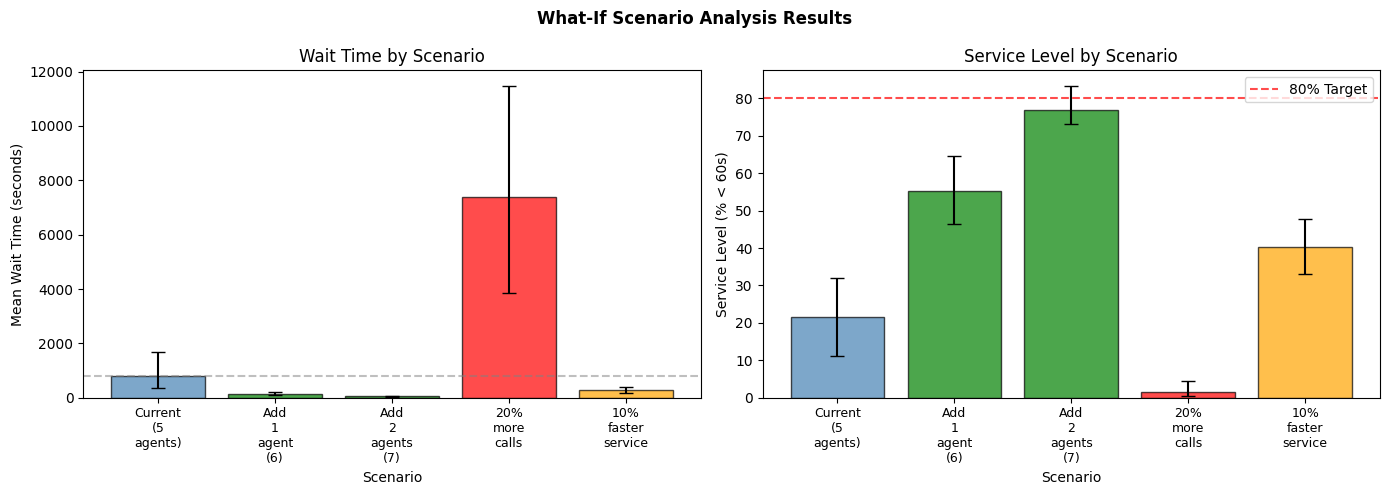

In [16]:
# Visualize scenario comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

scenario_names = list(scenarios.keys())
x = np.arange(len(scenario_names))

# Mean wait times with CI
waits = [scenarios[s]['mean_wait'] for s in scenario_names]
wait_errs = [[scenarios[s]['mean_wait'] - scenarios[s]['wait_ci'][0] for s in scenario_names],
             [scenarios[s]['wait_ci'][1] - scenarios[s]['mean_wait'] for s in scenario_names]]

colors = ['steelblue', 'green', 'green', 'red', 'orange']
bars1 = axes[0].bar(x, waits, color=colors, edgecolor='black', alpha=0.7)
axes[0].errorbar(x, waits, yerr=wait_errs, fmt='none', color='black', capsize=5)
axes[0].axhline(waits[0], color='gray', linestyle='--', alpha=0.5, label='Baseline')
axes[0].set_xlabel('Scenario')
axes[0].set_ylabel('Mean Wait Time (seconds)')
axes[0].set_title('Wait Time by Scenario')
axes[0].set_xticks(x)
axes[0].set_xticklabels([s.replace(' ', '\n') for s in scenario_names], fontsize=9)

# Service levels with CI
sls = [scenarios[s]['service_level'] for s in scenario_names]
sl_errs = [[scenarios[s]['service_level'] - scenarios[s]['sl_ci'][0] for s in scenario_names],
           [scenarios[s]['sl_ci'][1] - scenarios[s]['service_level'] for s in scenario_names]]

bars2 = axes[1].bar(x, sls, color=colors, edgecolor='black', alpha=0.7)
axes[1].errorbar(x, sls, yerr=sl_errs, fmt='none', color='black', capsize=5)
axes[1].axhline(80, color='red', linestyle='--', alpha=0.7, label='80% Target')
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('Service Level (% < 60s)')
axes[1].set_title('Service Level by Scenario')
axes[1].set_xticks(x)
axes[1].set_xticklabels([s.replace(' ', '\n') for s in scenario_names], fontsize=9)
axes[1].legend()

plt.suptitle('What-If Scenario Analysis Results', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## Part 7: Decision Support Report

In [17]:
# Generate decision support report
print("="*70)
print("OPERATIONS DECISION SUPPORT REPORT")
print("="*70)

print("\n1. DATA FOUNDATION")
print(f"   Historical data: {len(call_data):,} calls over 30 days")
print(f"   Inter-arrival model: {best_interarrival.distribution} (validated by KS test)")
print(f"   Service time model: {best_service.distribution} (validated by KS test)")

print("\n2. CURRENT STATE ANALYSIS")
current = scenarios['Current (5 agents)']
print(f"   Agents: 5")
print(f"   Mean wait: {current['mean_wait']:.1f}s")
print(f"   Service level (<60s): {current['service_level']:.1f}%")

print("\n3. SCENARIO RECOMMENDATIONS")

# Hiring recommendation
add1 = scenarios['Add 1 agent (6)']
add2 = scenarios['Add 2 agents (7)']
wait_reduction_1 = (current['mean_wait'] - add1['mean_wait']) / current['mean_wait'] * 100
wait_reduction_2 = (current['mean_wait'] - add2['mean_wait']) / current['mean_wait'] * 100

print(f"\n   OPTION A: Hire 1 Additional Agent")
print(f"   - Wait time reduction: {wait_reduction_1:.0f}%")
print(f"   - Service level improvement: +{add1['service_level'] - current['service_level']:.1f}pp")

print(f"\n   OPTION B: Hire 2 Additional Agents")
print(f"   - Wait time reduction: {wait_reduction_2:.0f}%")
print(f"   - Service level improvement: +{add2['service_level'] - current['service_level']:.1f}pp")

# Training recommendation
training = scenarios['10% faster service']
print(f"\n   OPTION C: Invest in Training (10% handle time reduction)")
print(f"   - Wait time reduction: {(current['mean_wait'] - training['mean_wait']) / current['mean_wait'] * 100:.0f}%")
print(f"   - Service level improvement: +{training['service_level'] - current['service_level']:.1f}pp")
print(f"   - No additional headcount required")

# Risk assessment
growth = scenarios['20% more calls']
print(f"\n4. RISK ASSESSMENT")
print(f"   If call volume increases 20%:")
print(f"   - Mean wait would increase to {growth['mean_wait']:.0f}s (+{(growth['mean_wait']/current['mean_wait']-1)*100:.0f}%)")
print(f"   - Service level would drop to {growth['service_level']:.1f}%")

print("\n5. RECOMMENDATION")
if current['service_level'] < 80:
    print("   Current service level is BELOW 80% target.")
    print("   RECOMMEND: Hire 1-2 additional agents or invest in training.")
else:
    print("   Current service level MEETS 80% target.")
    print("   RECOMMEND: Monitor call volume growth; plan for contingency staffing.")

print("\n" + "="*70)

OPERATIONS DECISION SUPPORT REPORT

1. DATA FOUNDATION
   Historical data: 17,320 calls over 30 days
   Inter-arrival model: betaprime (validated by KS test)
   Service time model: betaprime (validated by KS test)

2. CURRENT STATE ANALYSIS
   Agents: 5
   Mean wait: 796.0s
   Service level (<60s): 21.6%

3. SCENARIO RECOMMENDATIONS

   OPTION A: Hire 1 Additional Agent
   - Wait time reduction: 82%
   - Service level improvement: +33.7pp

   OPTION B: Hire 2 Additional Agents
   - Wait time reduction: 94%
   - Service level improvement: +55.3pp

   OPTION C: Invest in Training (10% handle time reduction)
   - Wait time reduction: 66%
   - Service level improvement: +18.5pp
   - No additional headcount required

4. RISK ASSESSMENT
   If call volume increases 20%:
   - Mean wait would increase to 7396s (+829%)
   - Service level would drop to 1.7%

5. RECOMMENDATION
   Current service level is BELOW 80% target.
   RECOMMEND: Hire 1-2 additional agents or invest in training.



## Summary

This notebook demonstrated the full workflow for simulation-based decision making:

1. **Data Collection**: Loaded operational data (arrivals, service times)
2. **Distribution Fitting**: Used spark-bestfit to identify the best distributions
3. **Assumption Validation**: Tested whether common assumptions (exponential) hold
4. **Queue Simulation**: Built a realistic G/G/c queue using fitted distributions
5. **Scenario Analysis**: Ran what-if simulations with confidence intervals
6. **Decision Support**: Generated actionable recommendations

### Key spark-bestfit Features Used

| Feature | Purpose |
|---------|----------|
| `DistributionFitter` | Fit service times, inter-arrival times |
| `DiscreteDistributionFitter` | Fit hourly call volumes |
| `lazy_metrics=False` | Validate with KS/AD tests |
| `get_scipy_dist()` | Sample from fitted distributions |
| `metric='aic'` | Select best predictive model |

### Business Value

- **Avoid costly experiments**: Test scenarios in simulation first
- **Quantify uncertainty**: Confidence intervals on predictions
- **Validate assumptions**: Don't blindly assume exponential distributions
- **Data-driven decisions**: Replace intuition with evidence

In [18]:
# Cleanup
spark.stop()